<a href="https://colab.research.google.com/github/hnm15/DS703/blob/main/Homework_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 8: Predicting Power Loads with LSTM Networks

## Due: Midnight on **Wednesday, October 29th** (with a 2-hour grace period)  
**Worth:** 85 points

In this assignment, you’ll build and analyze recurrent neural-network models to forecast hourly power demand, using the direct method, and comparing it with autoregressive methods.

**Direct (Non-Autoregressive) Time Series Prediction:**

![Screenshot 2025-10-19 at 11.17.16 AM.png](attachment:6c30ce0c-0c19-42ac-8a65-5623e080fad8.png)


**What we'll do in this homework**

Starting from a working LSTM baseline, you’ll experiment with how the **direct** forcasting models performs, and investigate how **lookback**, **forecast horizon**, and **architecture** affect predictive accuracy and generalization.  
You’ll also explore an **autoregressive** variant, where the model rolls forward one hour at a time—an approach that often highlights how small errors can accumulate.

You’ll complete three problems:

* **Problem 1 — Exploring Lookback and Horizon:**  
  Adjust how far back the model looks and how far ahead it predicts, and examine how these design choices influence MAE/RMSE.

* **Problem 2 — Architectural Tweaks:**  
  Modify the LSTM architecture by deepening the network, stacking layers, or adding a bidirectional layer, and evaluate the effect on validation performance.

* **Problem 3 — Autoregressive Forecasting (ChatGPT Discussion):**  
  Work interactively with ChatGPT to design a one-step-at-a-time autoregressive version of your model, and discuss how it compares to your direct multi-output model.



For each problem, you'll report your best validation metrics, display the learning-curve plots, and briefly reflect on what you learned from the experiment.

There are 5 graded problems, worth 17 points each.

## Setup and Data Loading


In [51]:
# ---------- Standard Library ----------
import os
import time
import math
import random
from pathlib import Path
from collections import Counter

# Environment (set BEFORE importing TensorFlow)
os.environ["PYTHONHASHSEED"] = "0"        # Disable hash randomization
os.environ["TF_DETERMINISTIC_OPS"] = "1"  # Deterministic TF ops where possible
os.environ["TF_CUDNN_DETERMINISM"] = "1"  # Deterministic CuDNN (if GPU)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppress TF INFO/WARNING logs

# ---------- Third-Party (General) ----------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit, ShuffleSplit
import kagglehub

# ---------- TensorFlow / Keras ----------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks, regularizers, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.layers import GlobalMaxPooling1D, SpatialDropout1D, Bidirectional
# Layers (vision)
from tensorflow.keras.layers import (
    Input, Conv2D,Conv1D, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D,
    GlobalMaxPooling2D, BatchNormalization, ReLU, Flatten, Dense, Dropout
)

# Preprocessing (vision)
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# ---------- (Optional) NLP-related imports ----------
# If not doing NLP, you can safely remove this block.
from tensorflow.keras.layers import (
    Embedding, GlobalAveragePooling1D, LSTM, GRU, SpatialDropout1D, Bidirectional, Lambda
)
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.datasets import imdb  # uncomment only if needed

# ---------- Reproducibility ----------
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)  # covers TF, Python, and NumPy RNGs

# ---------- Convenience ----------
he = initializers.HeNormal()
l2reg = regularizers.l2(1e-4)

def format_hms(seconds: float) -> str:
    """Format seconds as H:MM:SS."""
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

# Example:
# start = time.time()
# ... your code ...
# print("Elapsed:", format_hms(time.time() - start))


### Utility function to plot learning curves and keep track of all results

- Call `print_results()` to see listing of all results logged so far

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Single global registry (scaled units)
results = {}   # title -> dict with selected-epoch metrics and (optional) diagnostics

def plot_learning_curves_scaled(
    history,
    title="Learning Curves — MAE & RMSE (scaled)",
    verbose=True,
    record_globals=False,   # set True if you also want global minima as diagnostics
):
    """
    Plot MAE/RMSE directly from Keras History (scaled units).
    Select the epoch by min `val_loss` and record all metrics at that epoch.
    """
    H = history.history if hasattr(history, "history") else history
    if not isinstance(H, dict):
        raise ValueError("history must be a Keras History or a dict")

    if "loss" not in H:
        raise ValueError("History must contain 'loss' (MSE).")

    has_val_loss = "val_loss" in H and len(H["val_loss"]) > 0

    loss     = np.asarray(H["loss"], dtype=float)
    val_loss = np.asarray(H["val_loss"], dtype=float) if has_val_loss else None

    mae      = np.asarray(H["mae"], dtype=float)      if "mae"      in H else None
    val_mae  = np.asarray(H["val_mae"], dtype=float)  if "val_mae"  in H else None
    rmse     = np.asarray(H["rmse"], dtype=float)     if "rmse"     in H else np.sqrt(loss)
    val_rmse = np.asarray(H["val_rmse"], dtype=float) if "val_rmse" in H else (np.sqrt(val_loss) if has_val_loss else None)

    epochs = np.arange(1, len(loss) + 1)

    # ----- Select epoch by min val_loss (or last if no validation) -----
    if has_val_loss:
        sel_idx = int(np.argmin(val_loss))
        sel_note = "min val_loss"
    else:
        sel_idx = len(loss) - 1
        sel_note = "last epoch (no validation)"

    # Values at the selected epoch
    sel = {
        "epoch": sel_idx + 1,
        "selected_by": sel_note,
        "loss": float(loss[sel_idx]),
        "val_loss": float(val_loss[sel_idx]) if has_val_loss else np.nan,
        "mae": float(mae[sel_idx]) if mae is not None else np.nan,
        "val_mae": float(val_mae[sel_idx]) if val_mae is not None and has_val_loss else np.nan,
        "rmse": float(rmse[sel_idx]) if rmse is not None else (float(np.sqrt(loss[sel_idx])) if np.isfinite(loss[sel_idx]) else np.nan),
        "val_rmse": (
            float(val_rmse[sel_idx]) if (val_rmse is not None and has_val_loss)
            else (float(np.sqrt(val_loss[sel_idx])) if has_val_loss and np.isfinite(val_loss[sel_idx]) else np.nan)
        ),
    }

    # Optional: global minima diagnostics
    globs = {}
    if record_globals:
        if val_rmse is not None:
            i = int(np.argmin(val_rmse))
            globs.update(min_val_rmse=float(val_rmse[i]), epoch_min_val_rmse=i+1)
        if val_mae is not None:
            j = int(np.argmin(val_mae))
            globs.update(min_val_mae=float(val_mae[j]), epoch_min_val_mae=j+1)

    # ----- Plot (scaled units) -----
    fig, ax = plt.subplots(figsize=(8, 5))
    if rmse is not None:
        ax.plot(epochs, rmse, label="train RMSE (scaled)")
    if val_rmse is not None:
        ax.plot(epochs, val_rmse, label="val RMSE (scaled)")
    if mae is not None:
        ax.plot(epochs, mae, linestyle="--", label="train MAE (scaled)")
    if val_mae is not None:
        ax.plot(epochs, val_mae, linestyle="--", label="val MAE (scaled)")

    # Mark the selected epoch on validation curves
    if has_val_loss and (val_rmse is not None or val_mae is not None):
        if val_rmse is not None:
            ax.scatter(sel["epoch"], sel["val_rmse"], marker="x", s=70,
                       label=f"val RMSE @ {sel_note} = {sel['val_rmse']:.3g} (ep {sel['epoch']})")
        if val_mae is not None:
            ax.scatter(sel["epoch"], sel["val_mae"], marker="o", s=50,
                       label=f"val MAE @ {sel_note} = {sel['val_mae']:.3g} (ep {sel['epoch']})")

    ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Error (scaled units)")
    ax.grid(True, linestyle=":", alpha=0.6)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ----- Record (scaled) -----
    final = {
        "selected_epoch": sel["epoch"],
        "selected_by": sel["selected_by"],
        "val_mae_at_min_valloss": sel["val_mae"],
        "val_rmse_at_min_valloss": sel["val_rmse"],
        "train_mae_at_sel": sel["mae"],
        "train_rmse_at_sel": sel["rmse"],
        # keep last-epoch values if you want them too:
        "final_train_rmse": float(rmse[-1])     if rmse is not None else np.nan,
        "final_val_rmse":   float(val_rmse[-1]) if val_rmse is not None else np.nan,
        "final_train_mae":  float(mae[-1])      if mae is not None else np.nan,
        "final_val_mae":    float(val_mae[-1])  if val_mae is not None else np.nan,
        "units":            "scaled",
    }
    final.update(globs)  # add diagnostics if requested

    if verbose:
        print(f"Selected epoch: {final['selected_epoch']} ({final['selected_by']})")
        print(f"Valid @ sel —  MAE: {final['val_mae_at_min_valloss']:.4g} | RMSE: {final['val_rmse_at_min_valloss']:.4g} (scaled)")
        print(f"Train @ sel —  MAE: {final['train_mae_at_sel']:.4g}  | RMSE: {final['train_rmse_at_sel']:.4g} (scaled)")

    results[title] = final


def print_results(sort_by="val_rmse_at_min_valloss"):
    if not results:
        print("No results recorded yet."); return
    ordering = sorted(results.items(), key=lambda kv: kv[1].get(sort_by, np.inf))
    for name, info in ordering:
        print(f"{name:<35}  val_RMSE@min_val_loss={info.get('val_rmse_at_min_valloss', np.nan):.4g} "
              f"| val_MAE@min_val_loss={info.get('val_mae_at_min_valloss', np.nan):.4g} "
              f"| epoch={info.get('selected_epoch')}  (scaled)")


###  Wrapper for training and testing

#### Assumptions:   
- Early stopping is default, add other callbacks as needed
- Uses "binary_crossentropy" for binary classification task.
- Assumes `X_train,y_train,X_val,y_val,X_test,y_test` already defined, accessed here as global variables, or can specify them when calling
    - If you don’t pass X_train, it will look in the global namespace at call time.
    - If you do pass an explicit X_train=..., that value takes priority.
  
>      # uses global X_train, y_train, ...
>      train_and_test(model)
>
>      # uses explicitly passed datasets
>      train_and_test(model, X_train=new_X, y_train=new_y)

In [53]:
import time
import numpy as np
import tensorflow as tf
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from tensorflow.keras.callbacks import EarlyStopping

def train_and_test(
    model,
    X_train=None, y_train=None,
    X_val=None,   y_val=None,
    X_test=None,  y_test=None,
    *,
    epochs=50,
    optimizer="Adam",
    lr_schedule=1e-3,
    clipnorm=1.0,
    loss="mse",                         # keep MSE for training
    metrics=("mae", "rmse"),            # track MAE & RMSE in curves
    validation_split=0.2,
    random_state=42,
    title="Learning Curves (MSE loss; MAE & RMSE tracked)",
    batch_size=64,
    use_early_stopping=True,
    patience=5,
    min_delta=1e-4,
    callbacks=None,
    verbose=0,
    return_history=False,
    plot_scaled_curves=True,            # uses plot_learning_curves_scaled if available
):
    """
    Trains with MSE and tracks MAE/RMSE. Selects the epoch by min `val_loss`,
    and reports *all* metrics at that same epoch to avoid cherry-picking.
    Returns (history, test_results, info) if return_history=True else (test_results, info).
    """

    # ---------- Resolve datasets lazily from globals if not provided ----------
    g = globals()
    X_train = X_train if X_train is not None else g.get("X_train")
    y_train = y_train if y_train is not None else g.get("y_train")
    X_val   = X_val   if X_val   is not None else g.get("X_val")
    y_val   = y_val   if y_val   is not None else g.get("y_val")
    X_test  = X_test  if X_test  is not None else g.get("X_test")
    y_test  = y_test  if y_test  is not None else g.get("y_test")

    # ---------- Basic checks ----------
    if X_train is None or y_train is None:
        raise ValueError("Training data (X_train, y_train) not provided or defined globally.")
    if X_test is None or y_test is None:
        raise ValueError("Test data (X_test, y_test) not provided or defined globally.")

    # ---------- If no explicit val provided, optionally create one from training ----------
    made_internal_val = False
    if X_val is None or y_val is None:
        if validation_split and validation_split > 0.0:
            X_tr = np.asarray(X_train)
            y_tr = np.asarray(y_train)
            test_size = float(validation_split)

            def _is_single_label_classification(y):
                try:
                    y = np.asarray(y)
                    return np.issubdtype(y.dtype, np.integer) and (len(np.unique(y)) < max(20, 0.02*len(y)))
                except Exception:
                    return False

            if _is_single_label_classification(y_tr):
                splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
                (train_idx, val_idx), = splitter.split(X_tr, y_tr)
            else:
                splitter = ShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
                (train_idx, val_idx), = splitter.split(np.arange(len(X_tr)))

            X_train, y_train = X_tr[train_idx], y_tr[train_idx]
            X_val,   y_val   = X_tr[val_idx],   y_tr[val_idx]
            made_internal_val = True
        else:
            if use_early_stopping:
                raise ValueError("Early stopping needs validation. Provide (X_val, y_val) or set validation_split > 0.")

    if title:
        print(f"\n{title}\n")

    # ---------- Optimizer ----------
    if isinstance(optimizer, str):
        opt = getattr(tf.keras.optimizers, optimizer)(learning_rate=lr_schedule, clipnorm=clipnorm)
    else:
        opt = optimizer

    # ---------- Metrics ----------
    keras_metrics = []
    for m in metrics:
        if isinstance(m, str):
            key = m.lower()
            if key in ("mae", "meanabsoluteerror"):
                keras_metrics.append(tf.keras.metrics.MeanAbsoluteError(name="mae"))
            elif key in ("rmse", "rootmeansquarederror"):
                keras_metrics.append(tf.keras.metrics.RootMeanSquaredError(name="rmse"))
            elif key in ("mse", "meansquarederror"):
                keras_metrics.append(tf.keras.metrics.MeanSquaredError(name="mse"))
            else:
                keras_metrics.append(m)
        else:
            keras_metrics.append(m)

    model.compile(optimizer=opt, loss=loss, metrics=keras_metrics)

    # ---------- Callbacks ----------
    cb = [] if callbacks is None else list(callbacks)
    if use_early_stopping:
        cb = [EarlyStopping(monitor="val_loss", patience=patience, min_delta=min_delta,
                            restore_best_weights=True, verbose=verbose)] + cb

    # ---------- Fit ----------
    start = time.time()
    fit_kwargs = dict(
        x=X_train, y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=cb,
        verbose=verbose,
        shuffle=True,
    )
    if X_val is not None and y_val is not None:
        fit_kwargs["validation_data"] = (X_val, y_val)

    history = model.fit(**fit_kwargs)
    hist = history.history

    # ---------- Select epoch by min val_loss ----------
    if "val_loss" in hist and len(hist["val_loss"]) > 0:
        sel_idx = int(np.argmin(hist["val_loss"]))       # 0-based
        selected_by = "val_loss"
    else:
        # fallback: last epoch if no val set
        sel_idx = len(hist.get("loss", [])) - 1
        selected_by = "loss (no validation)"

    # Gather metrics at selected epoch (scaled units)
    def _get(name):
        v = hist.get(name, None)
        return float(v[sel_idx]) if v is not None and len(v) > sel_idx else float("nan")

    selected = {
        "epoch":         sel_idx + 1,
        "selected_by":   selected_by,
        "loss":          _get("loss"),
        "val_loss":      _get("val_loss"),
        "mae":           _get("mae"),
        "val_mae":       _get("val_mae"),
        "rmse":          _get("rmse") if "rmse" in hist else float(np.sqrt(_get("loss"))) if np.isfinite(_get("loss")) else float("nan"),
        "val_rmse":      _get("val_rmse") if "val_rmse" in hist else float(np.sqrt(_get("val_loss"))) if np.isfinite(_get("val_loss")) else float("nan"),
    }

    # ---------- Evaluate on test set (scaled units) ----------
    test_out = model.evaluate(X_test, y_test, verbose=0)
    metric_names = model.metrics_names
    test_results = dict(zip(metric_names, map(float, np.atleast_1d(test_out))))
    if "loss" in test_results:
        test_results["rmse_from_mse_loss"] = float(np.sqrt(test_results["loss"]))

    elapsed = time.time() - start

    # ---------- Console summary (report everything at selected epoch) ----------
    # print(f"Selected epoch: {selected['epoch']} (by {selected['selected_by']})")
    # print(f"Train @ sel —  LOSS: {selected['loss']:.6f} | MAE: {selected['mae']:.6f} | RMSE: {selected['rmse']:.6f}")
    # if np.isfinite(selected["val_loss"]):
    #     print(f"Valid @ sel —  LOSS: {selected['val_loss']:.6f} | MAE: {selected['val_mae']:.6f} | RMSE: {selected['val_rmse']:.6f}")
    # print("Test  (final weights after ES restore) — " +
    #       " | ".join([f"{k.upper()}: {v:.6f}" for k, v in test_results.items()]) +
    #       f"   (time: {elapsed:.1f}s)")

    # ---------- Optional: plot scaled curves & record to registry ----------
    if plot_scaled_curves and 'plot_learning_curves_scaled' in globals():
        plot_learning_curves_scaled(history, title=title, verbose=verbose)

    info = {
        "made_internal_val": made_internal_val,
        "elapsed_sec": elapsed,
        "selected_epoch": selected["epoch"],
        "selected_by": selected_by,
        "train_at_sel": {"loss": selected["loss"], "mae": selected["mae"], "rmse": selected["rmse"]},
        "val_at_sel":   {"loss": selected["val_loss"], "mae": selected["val_mae"], "rmse": selected["val_rmse"]},
    }

    if return_history:
        return history, test_results, info


### Learning Rate Schedulers

In [54]:
# Must be input as callback in train_and_test(....   , callbacks=[reduce_lr] )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Quantity to be monitored.
    factor=0.5,            # Factor by which the learning rate will be reduced.
                           # new_lr = lr * factor
    patience=5,            # Number of epochs with no improvement
                           # after which learning rate will be reduced.
    min_delta=1e-4,        # Threshold for measuring the new optimum,
                           # to only focus on significant changes.
    cooldown=0,            # Number of epochs to wait before resuming
                           # normal operation after lr has been reduced.
    min_lr=1e-8,           # Lower bound on the learning rate.
    verbose=0,             # 0: quiet, 1: update messages.
)

### Load and prepare data

Window kept: 2025-01-01 00:00:00  →  2025-05-31 23:00:00  (3624 hours)
Split sizes — train: 2536, val: 543, test: 545


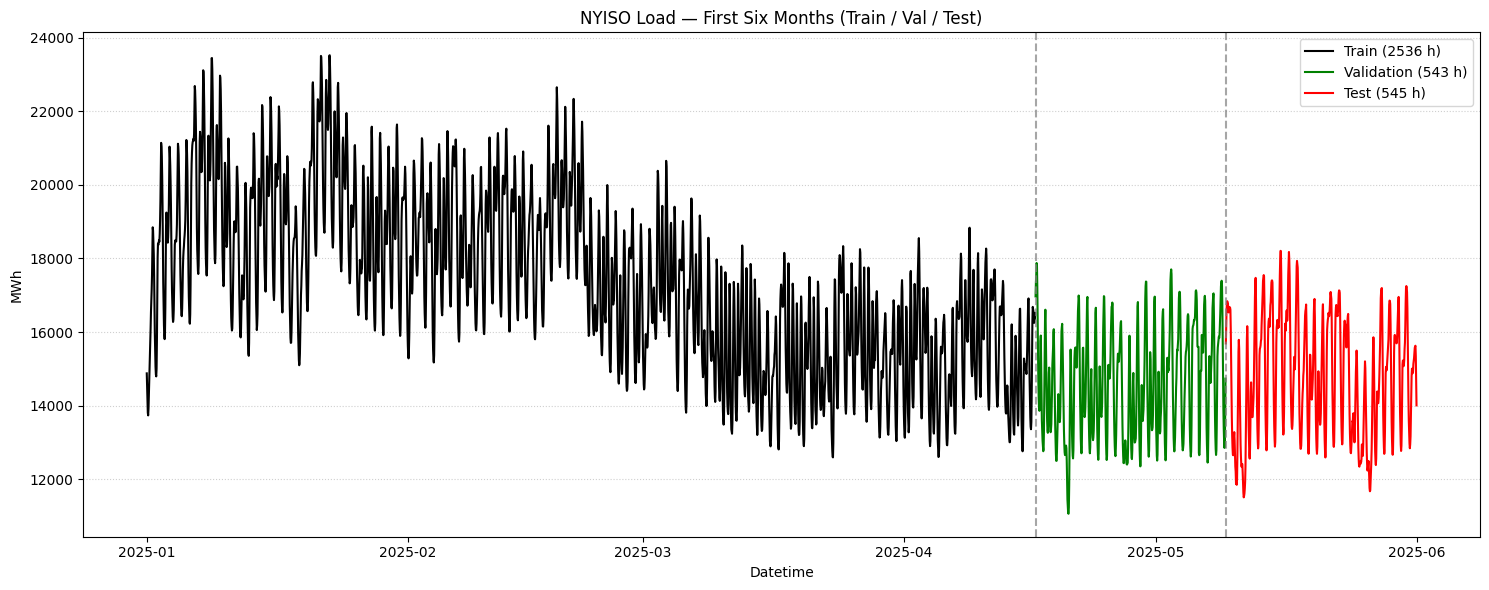


MegaWatts per Hour — First Six Months

Datetime
2025-01-01 00:00:00    14877.0
2025-01-01 01:00:00    14487.0
2025-01-01 02:00:00    14091.0
2025-01-01 03:00:00    13804.0
2025-01-01 04:00:00    13735.0
2025-01-01 05:00:00    13929.0
Freq: h, Name: NYISO_Load, dtype: float64
....
Datetime
2025-05-31 18:00:00    15571.0
2025-05-31 19:00:00    15610.0
2025-05-31 20:00:00    15628.0
2025-05-31 21:00:00    15342.0
2025-05-31 22:00:00    14727.0
2025-05-31 23:00:00    14007.0
Freq: h, Name: NYISO_Load, dtype: float64
Length: 3624 hours


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# --------------------------
# 0) Load & reshape (Hr1..Hr24 only)
# --------------------------
df = pd.read_csv("/nyiso_loads.csv")

# strictly keep Hr1..Hr24 (drop Hr25 if present)
hour_cols = sorted(
    [c for c in df.columns if re.fullmatch(r"Hr\d+", c) and 1 <= int(c[2:]) <= 24],
    key=lambda c: int(c[2:])
)

# wide -> long (1 row per hour)
long_df = df.melt(
    id_vars=["Year", "Month", "Day"],
    value_vars=hour_cols,
    var_name="Hour",
    value_name="Load"
).sort_values(["Year", "Month", "Day", "Hour"], ignore_index=True)

# datetime index
long_df["Datetime"] = (
    pd.to_datetime(long_df[["Year", "Month", "Day"]]) +
    pd.to_timedelta(long_df["Hour"].str.extract(r"(\d+)").astype(int)[0] - 1, unit="h")
)
long_df = long_df.sort_values("Datetime", ignore_index=True)

# series
load_series = pd.Series(long_df["Load"].values, index=long_df["Datetime"], name="NYISO_Load")
load_series.index.name = "Datetime"

# --------------------------
# 1) Keep ONLY the first six months from the series start
# --------------------------
start = load_series.index.min().normalize()
end   = start + pd.DateOffset(months=5)   # exclusive upper bound
s6    = load_series.loc[(load_series.index >= start) & (load_series.index < end)].copy()

# Enforce hourly cadence & light gap fill
s6 = s6.asfreq('h')             # pandas now prefers lowercase 'h'
s6 = s6.interpolate(limit=3)    # fill gaps up to 3 hours
s6 = s6.dropna()

print(f"Window kept: {s6.index[0]}  →  {s6.index[-1]}  ({len(s6)} hours)")

# --------------------------
# 2) Chronological split: 70% / 15% / 15%
# --------------------------
N       = len(s6)
n_train = int(0.70 * N)
n_val   = int(0.15 * N)
n_test  = N - n_train - n_val

idx_tr = slice(0, n_train)
idx_va = slice(n_train, n_train + n_val)
idx_te = slice(n_train + n_val, N)

t_train_end = s6.index[n_train]
t_val_end   = s6.index[n_train + n_val]

print(f"Split sizes — train: {n_train}, val: {n_val}, test: {n_test}")

# --------------------------
# 3) Plot Train / Val / Test
# --------------------------
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(s6.index[idx_tr], s6.values[idx_tr], color='black', label=f"Train ({n_train} h)")
ax.plot(s6.index[idx_va], s6.values[idx_va], color='green', label=f"Validation ({n_val} h)")
ax.plot(s6.index[idx_te], s6.values[idx_te], color='red',   label=f"Test ({n_test} h)")

ax.axvline(t_train_end, linestyle='--', color='gray', alpha=0.7)
ax.axvline(t_val_end,   linestyle='--', color='gray', alpha=0.7)

ax.set_title("NYISO Load — First Six Months (Train / Val / Test)")
ax.set_xlabel("Datetime")
ax.set_ylabel("MWh")
ax.grid(True, axis='y', linestyle=':', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()

# --------------------------
# 4) Quick peek & NumPy export
# --------------------------
print("\nMegaWatts per Hour — First Six Months\n")
print(s6.head(6))
print('....')
print(s6.tail(6))
print(f"Length: {len(s6)} hours")

# For RNN/LSTM training
load_array = s6.to_numpy().astype(np.float32)


#### Plot Last Two Weeks

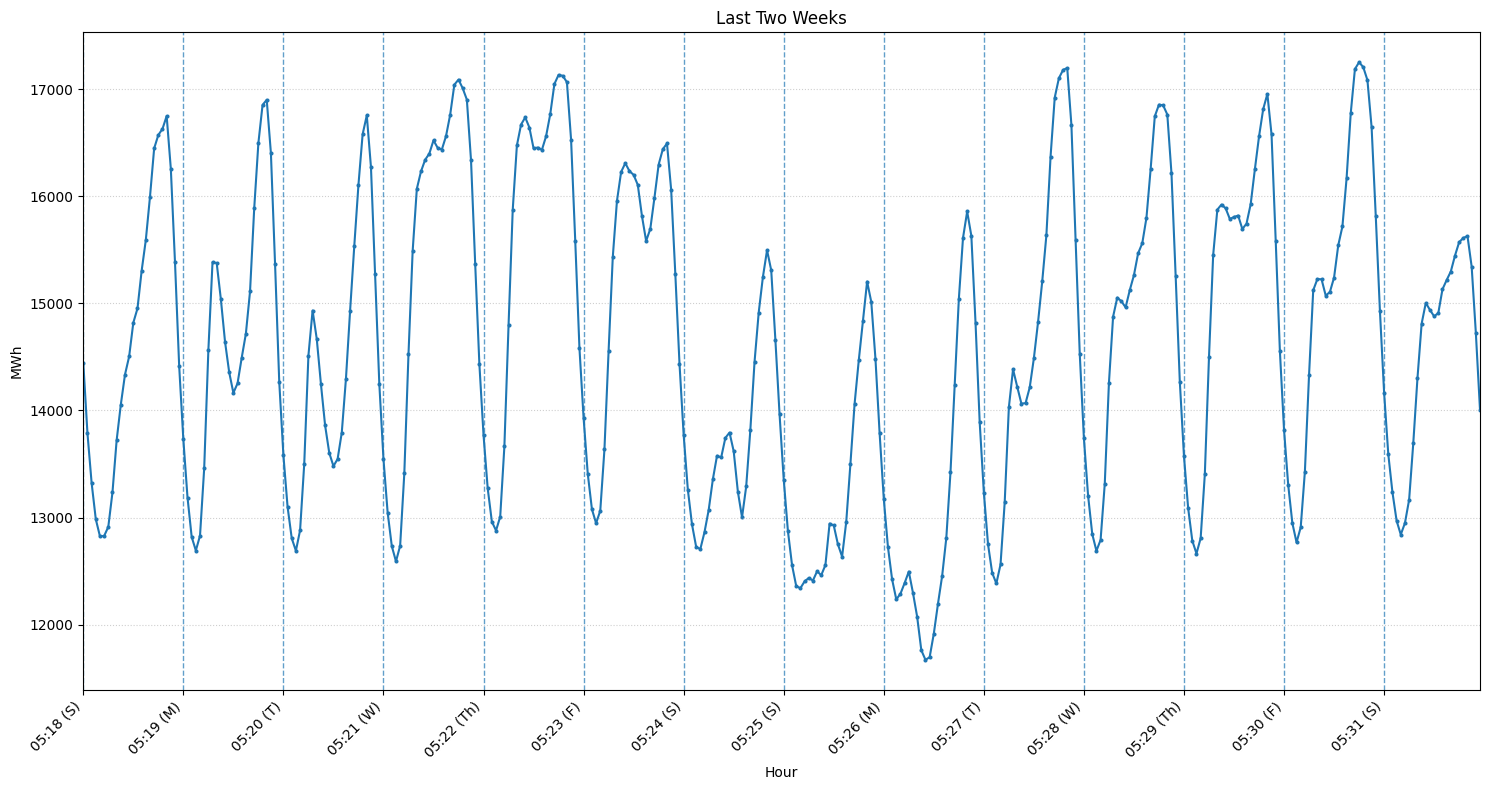

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Choose the series to plot (use s6 if you limited to first six months)
series = s6    # or load_series

period_hours = 24 * 14
sel = series.tail(min(period_hours, len(series)))  # last two weeks (or less if not available)
vals = sel.values

# positions of midnights within the selection
midnight_mask = sel.index.hour == 0
day_positions = np.nonzero(midnight_mask)[0]
day_times = sel.index[midnight_mask]

# weekday letter: Mon=M, Tue=T, Wed=W, Thu=Th, Fri=F, Sat/Sun=S
def wd_letter(ts: pd.Timestamp) -> str:
    dow = ts.dayofweek  # Mon=0 ... Sun=6
    if dow >= 5:
        return "S"
    return ["M", "T", "W", "Th", "F"][dow]

day_labels = [f"{t:%m}:{t:%d} ({wd_letter(t)})" for t in day_times]

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Last Two Weeks")
ax.plot(vals)
ax.scatter(range(len(vals)), vals, marker='.', s=15)

# vertical lines at each midnight
for x in day_positions:
    ax.axvline(x, linestyle='--', linewidth=1, alpha=0.7)

ax.set_xlim(0, len(vals) - 1)
ax.set_xlabel("Hour")
ax.set_ylabel("MWh")
ax.grid(True, axis='y', linestyle=':', alpha=0.6)

ax.set_xticks(day_positions)
ax.set_xticklabels(day_labels, rotation=45, ha="right")

plt.tight_layout()
plt.show()


### Preprocess Data into Sliding Windows


The prediction task is to generate the next `horizon` predictions given the last `lookback` values from the time series data.  

> Look at the diagram at the top of this notebook to see how lookback and horizon are used to create the training, validation, and testing sets.

**Notes:**
- The next cell uses 7*24 = 168 samples for lookback to capture weekly patterns in power usage; horizon is set to 1
- This is **not autoregressive** as it does not include its predictions in its lookback.
- Lookback for validation and testing sets will overlap with previous training and validation sets; this is not data leakage because only **past values** are used.
- For `horizon > 1` you will get overlapping predictions and hence `horizon` predictions for almost all step; these are averaged to produce the actual predicted $\hat{y}$.

In [57]:
# assume s6 exists (your Jan–Jun hourly Series), and you computed n_train, n_val
train = s6.iloc[:n_train]
val   = s6.iloc[n_train:n_train+n_val]
test  = s6.iloc[n_train+n_val:]

# --------------------------
# 3) Scaling (fit on train only)
# --------------------------

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x = scaler.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
val_x   = scaler.transform(val.values.reshape(-1,1)).astype(np.float32)
test_x  = scaler.transform(test.values.reshape(-1,1)).astype(np.float32)

# --------------------------
# 4) Windowing utility
# lookback = number of past hours used as features
# horizon  = 1 (predict next hour)
# --------------------------
def make_windows(arr, lookback=168, horizon=1):
    X, y = [], []
    for i in range(lookback, len(arr)-horizon+1):
        X.append(arr[i-lookback:i, 0])
        y.append(arr[i:i+horizon, 0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    # shapes: X -> (samples, lookback), y -> (samples, horizon)
    return X[..., None], y  # add feature dim -> (samples, lookback, 1)

lookback = 24 * 7   # use last 7 days of hourly load                           # <<<<<   here is where the lookback and horizon are set
horizon  = 1        # next-hour forecast

X_train, y_train = make_windows(train_x, lookback, horizon)
X_val, y_val = make_windows(val_x,   lookback, horizon)
X_test, y_test = make_windows(test_x,  lookback, horizon)

print("Shapes:")
print("  X_train:", X_train.shape, "y_test:", y_test.shape)
print("  X_val:", X_val.shape, "y_val:", y_val.shape)
print("  X_test:", X_test.shape, "y_test:", y_test.shape)

Shapes:
  X_train: (2368, 168, 1) y_test: (377, 1)
  X_val: (375, 168, 1) y_val: (375, 1)
  X_test: (377, 168, 1) y_test: (377, 1)


### Build a Baseline LSTM Model for lookback = 2 weeks, horizon = next hour


Baseline Model

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.8835 - mae: 0.7592 - rmse: 0.9343 - val_loss: 0.3210 - val_mae: 0.4924 - val_rmse: 0.5666
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3932 - mae: 0.5314 - rmse: 0.6266 - val_loss: 0.2912 - val_mae: 0.4565 - val_rmse: 0.5397
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3031 - mae: 0.4679 - rmse: 0.5502 - val_loss: 0.2134 - val_mae: 0.3837 - val_rmse: 0.4620
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2407 - mae: 0.4114 - rmse: 0.4901 - val_loss: 0.1478 - val_mae: 0.3209 - val_rmse: 0.3844
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1741 - mae: 0.3456 - rmse: 0.4168 - val_loss: 0.1061 - val_mae: 0.2753 - val_rmse: 0.3258
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1203 - mae: 0.2817 - rmse: 0.3468 - val_loss: 0.0700 - val_mae: 0.2287 - val_rmse: 0.2645
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0963 - mae: 0.24

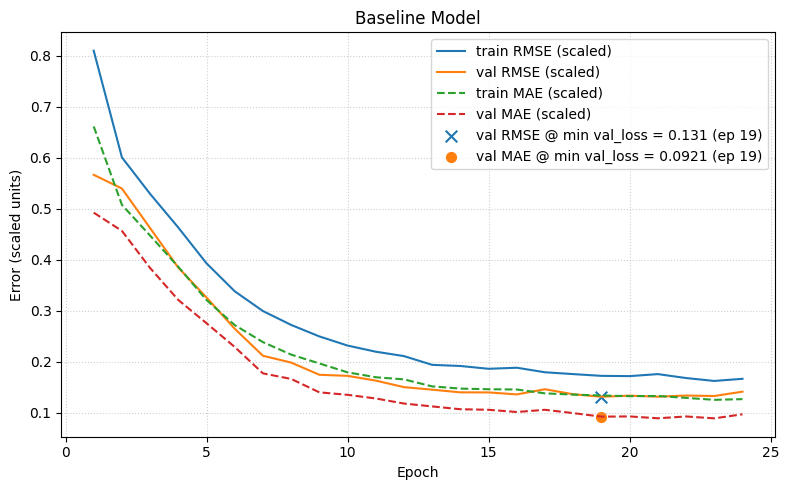

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.09209 | RMSE: 0.1311 (scaled)
Train @ sel —  MAE: 0.1335  | RMSE: 0.1721 (scaled)


In [58]:
# Baseline LSTM model

hn = keras.initializers.HeNormal(seed=random_seed)

baseline_model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=hn),
    Dense(horizon)
])


train_and_test( baseline_model,title="Baseline Model",verbose=1)

### Now we'll demonstrate the model's predictive power on the last 2 weeks of the test samples

Test RMSE (avg over all steps): 0.097 (scaled)
Test  MAE (avg over all steps): 0.081 (scaled)


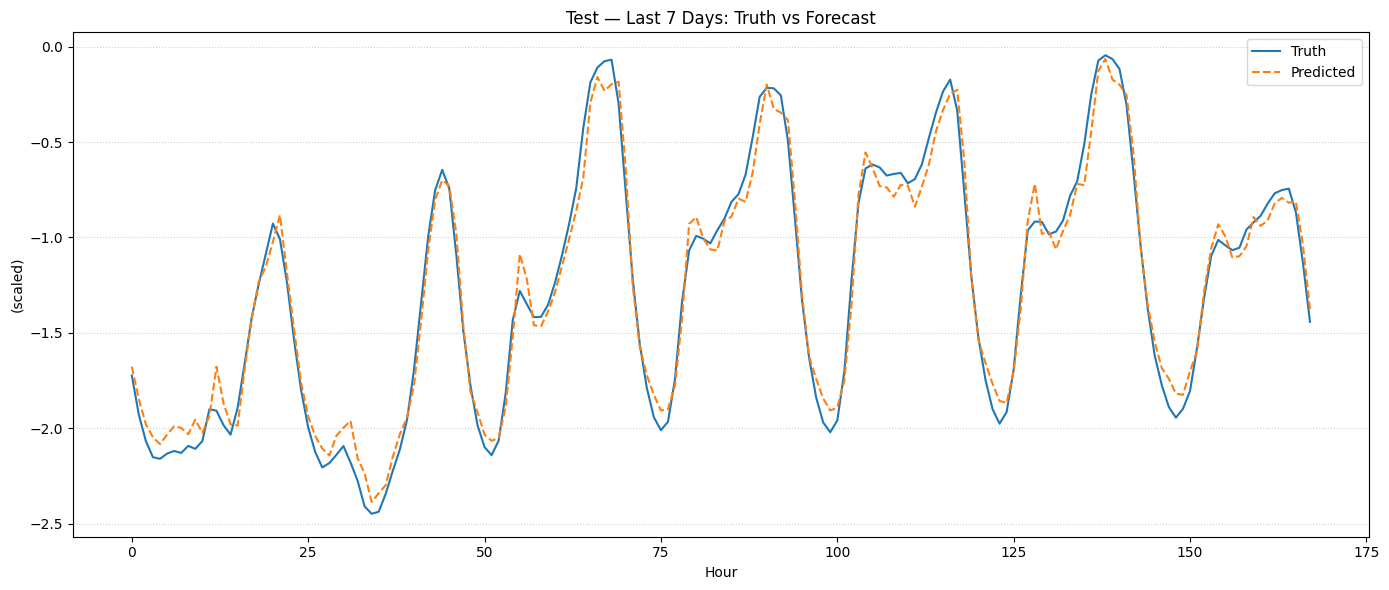

In [59]:
def evaluate_on_test(
    model,
    *,
    target_scaler=None,          # pass your y scaler here if you want original units
    report_in_scaled=True,       # set False to invert to original units
    unit_scaled="(scaled)",
    unit_original="MW",          # or "MWh" if your target is energy, not power
    plot_last_hours=24*7,
):
    """
    Evaluate on X_test/y_test and plot the last `plot_last_hours` predictions.
    Supports horizon=1 and direct multi-output (H>1).
    """
    # 1) Predict
    y_pred = model.predict(X_test, verbose=0)         # (n_windows, H) or (n_windows, 1)
    if y_pred.ndim == 1:
        y_pred = y_pred[:, None]
    H = y_pred.shape[1]

    # 2) Choose units (scaled vs original)
    def maybe_invert(arr):
        if report_in_scaled or target_scaler is None:
            return arr
        a = np.asarray(arr).reshape(-1, 1)
        return target_scaler.inverse_transform(a).ravel()

    # 3) Build comparable arrays for metrics
    # y_test matches y_pred shape: (n_windows, H)
    y_true = y_test
    # Metrics (per-horizon and averaged) in chosen units
    err = maybe_invert(y_pred.ravel()) - maybe_invert(y_true.ravel())
    rmse_avg = float(np.sqrt(np.mean(err**2)))
    mae_avg  = float(np.mean(np.abs(err)))

    if H > 1:
        # per-horizon
        y_true_u = maybe_invert(y_true)
        y_pred_u = maybe_invert(y_pred)
        mae_per_h  = np.mean(np.abs(y_true_u - y_pred_u), axis=0)
        rmse_per_h = np.sqrt(np.mean((y_true_u - y_pred_u)**2, axis=0))

    # 4) Prepare a single timeline for plotting
    def stitch_direct_predictions(yhat):
        """Average overlaps for direct multi-step predictions."""
        n, HH = yhat.shape
        total = n + HH - 1
        out = np.zeros(total, dtype=float)
        cnt = np.zeros(total, dtype=float)
        for i in range(n):
            out[i:i+HH] += yhat[i]
            cnt[i:i+HH] += 1.0
        return out / np.maximum(cnt, 1.0)

    # Choose units for plotting
    unit = unit_scaled if (report_in_scaled or target_scaler is None) else unit_original

    if H == 1:
        y_true_t = maybe_invert(y_true.ravel())
        y_pred_t = maybe_invert(y_pred.ravel())
    else:
        # stitch both for a continuous timeline
        y_pred_t = stitch_direct_predictions(maybe_invert(y_pred))
        y_true_t = stitch_direct_predictions(maybe_invert(y_true))

    # 5) Print summary
    print(f"Test RMSE (avg over all steps): {rmse_avg:,.3f} {unit}")
    print(f"Test  MAE (avg over all steps): {mae_avg:,.3f} {unit}")
    if H > 1:
        print("Per-horizon (0 = 1-step ahead):")
        print("  MAE :", np.round(mae_per_h, 3))
        print("  RMSE:", np.round(rmse_per_h, 3))

    # 6) Plot last N hours
    N = min(plot_last_hours, len(y_true_t))
    plt.figure(figsize=(14, 6))
    plt.title("Test — Last 7 Days: Truth vs Forecast")
    plt.plot(y_true_t[-N:], label="Truth")
    plt.plot(y_pred_t[-N:], label="Predicted", linestyle="--")
    plt.xlabel("Hour")
    plt.ylabel(unit)
    plt.grid(True, axis='y', linestyle=':', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

evaluate_on_test(baseline_model)

## Problem One — Exploring Lookback and Horizon

Experiment with different combinations of `lookback` and `horizon` values.  
For example, you might double the lookback window (e.g., from 1 week to 2 weeks) or extend the prediction horizon to 24 hours.  

After each change:
- Retrain your model.
- Use `evaluate_on_test(...)` to visualize the extended 2-week prediction.
- Compare validation and test MAE/RMSE across experiments.
- Answer the graded questions.

> *Note:* You’ll need to adjust the data-preparation cell above to rebuild the training, validation, and testing sets with the new parameters.



LB=24, H=1

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.6952 - mae: 0.6947 - rmse: 0.8321 - val_loss: 0.3816 - val_mae: 0.5292 - val_rmse: 0.6177
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3453 - mae: 0.4996 - rmse: 0.5875 - val_loss: 0.2612 - val_mae: 0.4396 - val_rmse: 0.5111
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2648 - mae: 0.4324 - rmse: 0.5144 - val_loss: 0.1562 - val_mae: 0.3417 - val_rmse: 0.3953
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1711 - mae: 0.3458 - rmse: 0.4136 - val_loss: 0.0902 - val_mae: 0.2583 - val_rmse: 0.3003
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1185 - mae: 0.2780 - rmse: 0.3442 - val_loss: 0.0844 - val_mae: 0.2464 - val_rmse: 0.2905
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0855 - mae: 0.2324 - rmse: 0.2924 - val_loss: 0.0597 - val_mae: 0.2057 - val_rmse: 0.2443
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0648 - mae: 0.1997 - rmse:

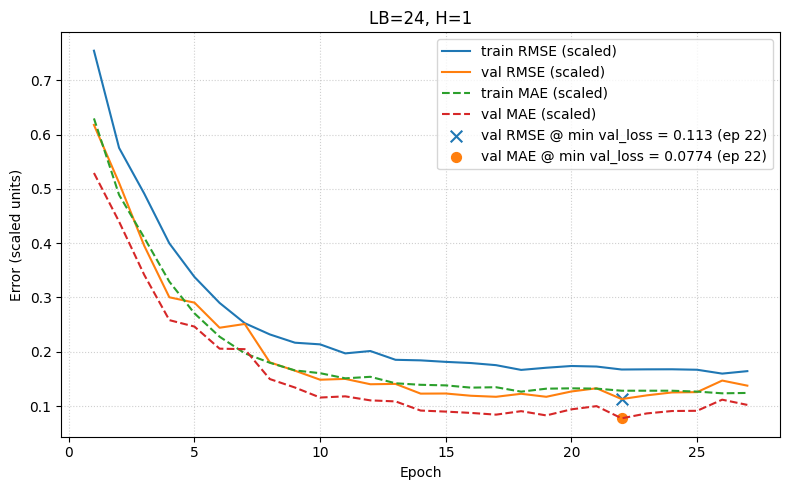

Selected epoch: 22 (min val_loss)
Valid @ sel —  MAE: 0.07743 | RMSE: 0.1129 (scaled)
Train @ sel —  MAE: 0.1283  | RMSE: 0.1673 (scaled)
Lookback=24, Horizon=1 -> Val MAE=0.077429

LB=72, H=1

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7097 - mae: 0.6893 - rmse: 0.8402 - val_loss: 0.3916 - val_mae: 0.5266 - val_rmse: 0.6258
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3737 - mae: 0.5226 - rmse: 0.6112 - val_loss: 0.3481 - val_mae: 0.4909 - val_rmse: 0.5900
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2906 - mae: 0.4584 - rmse: 0.5389 - val_loss: 0.2817 - val_mae: 0.4357 - val_rmse: 0.5308
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2139 - mae: 0.3886 - rmse: 0.4622 - val_loss: 0.1996 - val_mae: 0.3706 - val_rmse: 0.4467
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1491 - mae: 0.3164 - rmse: 0.3860 - val_loss: 0.1186 - val_mae: 0.2925 - val_rmse: 0.3444
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - los

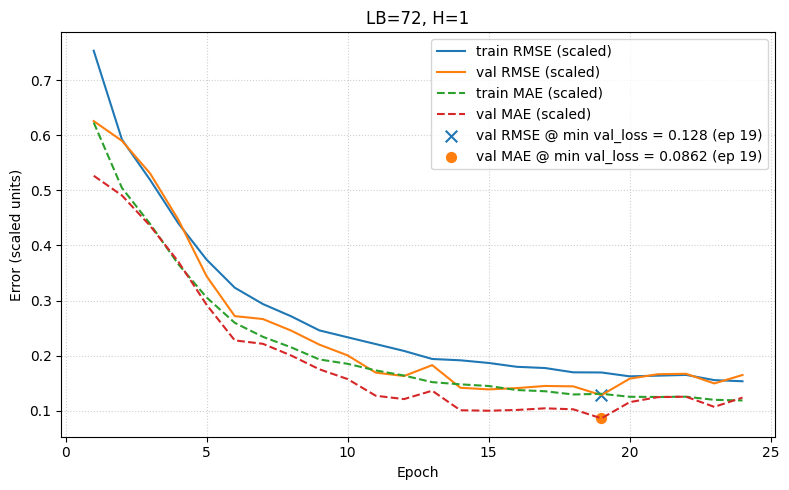

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.08624 | RMSE: 0.1284 (scaled)
Train @ sel —  MAE: 0.1308  | RMSE: 0.1695 (scaled)
Lookback=72, Horizon=1 -> Val MAE=0.086243

LB=168, H=1

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.6565 - mae: 0.6549 - rmse: 0.8064 - val_loss: 0.3708 - val_mae: 0.5090 - val_rmse: 0.6089
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3643 - mae: 0.5163 - rmse: 0.6031 - val_loss: 0.3063 - val_mae: 0.4638 - val_rmse: 0.5535
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2858 - mae: 0.4503 - rmse: 0.5342 - val_loss: 0.2500 - val_mae: 0.4199 - val_rmse: 0.5000
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2230 - mae: 0.3962 - rmse: 0.4717 - val_loss: 0.1919 - val_mae: 0.3669 - val_rmse: 0.4381
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1660 - mae: 0.3416 - rmse: 0.4074 - val_loss: 0.1383 - val_mae: 0.3138 - val_rmse: 0.3719
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

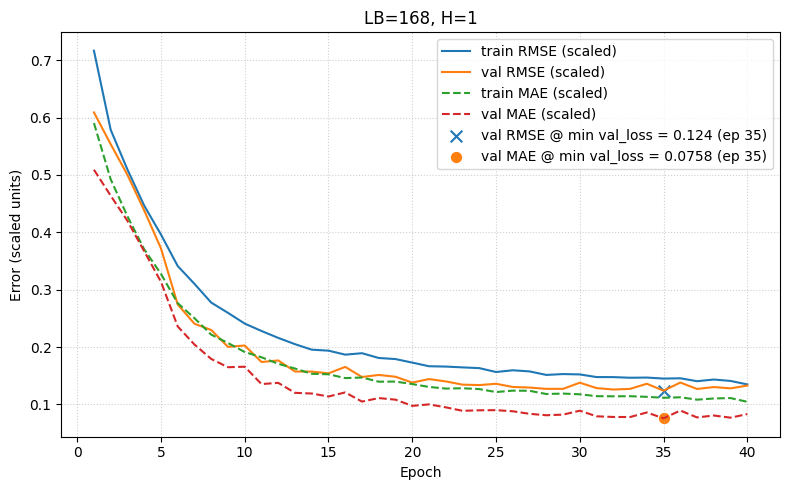

Selected epoch: 35 (min val_loss)
Valid @ sel —  MAE: 0.07578 | RMSE: 0.1239 (scaled)
Train @ sel —  MAE: 0.1116  | RMSE: 0.1451 (scaled)
Lookback=168, Horizon=1 -> Val MAE=0.075784

LB=336, H=1

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.8897 - mae: 0.7850 - rmse: 0.9411 - val_loss: 0.4946 - val_mae: 0.5778 - val_rmse: 0.7033
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4116 - mae: 0.5483 - rmse: 0.6411 - val_loss: 0.3334 - val_mae: 0.4805 - val_rmse: 0.5774
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3160 - mae: 0.4790 - rmse: 0.5618 - val_loss: 0.2262 - val_mae: 0.3841 - val_rmse: 0.4756
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2378 - mae: 0.4115 - rmse: 0.4873 - val_loss: 0.1445 - val_mae: 0.3012 - val_rmse: 0.3802
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1633 - mae: 0.3371 - rmse: 0.4038 - val_loss: 0.0787 - val_mae: 0.2393 - val_rmse: 0.2805
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/ste

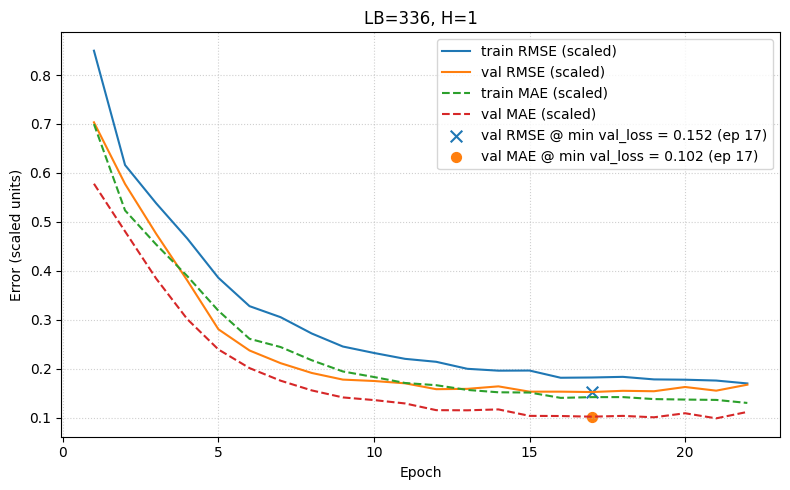

Selected epoch: 17 (min val_loss)
Valid @ sel —  MAE: 0.102 | RMSE: 0.1523 (scaled)
Train @ sel —  MAE: 0.1419  | RMSE: 0.182 (scaled)
Lookback=336, Horizon=1 -> Val MAE=0.101968

LB=168, H=6

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9379 - mae: 0.7985 - rmse: 0.9679 - val_loss: 0.6053 - val_mae: 0.6445 - val_rmse: 0.7780
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5447 - mae: 0.6116 - rmse: 0.7379 - val_loss: 0.5309 - val_mae: 0.6075 - val_rmse: 0.7286
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4878 - mae: 0.5834 - rmse: 0.6983 - val_loss: 0.4841 - val_mae: 0.5844 - val_rmse: 0.6957
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4685 - mae: 0.5716 - rmse: 0.6843 - val_loss: 0.4625 - val_mae: 0.5728 - val_rmse: 0.6801
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4578 - mae: 0.5663 - rmse: 0.6765 - val_loss: 0.4593 - val_mae: 0.5709 - val_rmse: 0.6777
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

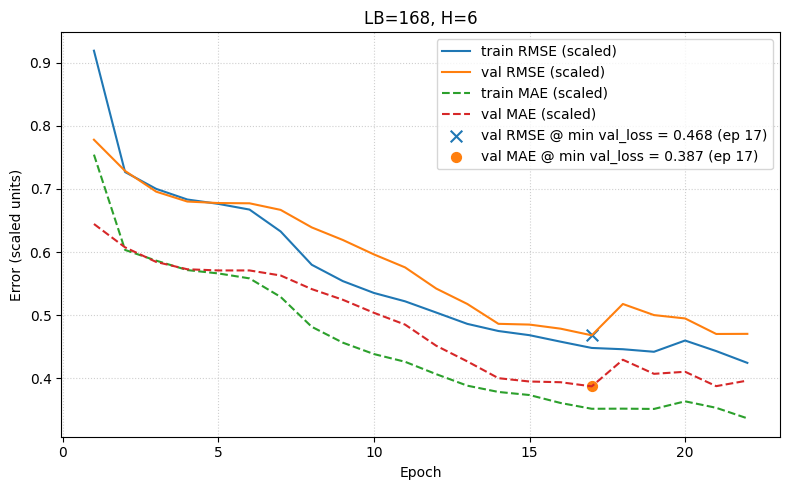

Selected epoch: 17 (min val_loss)
Valid @ sel —  MAE: 0.3873 | RMSE: 0.4681 (scaled)
Train @ sel —  MAE: 0.3517  | RMSE: 0.4481 (scaled)
Lookback=168, Horizon=6 -> Val MAE=0.387260

LB=168, H=12

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9389 - mae: 0.8003 - rmse: 0.9686 - val_loss: 0.6994 - val_mae: 0.6869 - val_rmse: 0.8363
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6100 - mae: 0.6423 - rmse: 0.7808 - val_loss: 0.5031 - val_mae: 0.5938 - val_rmse: 0.7093
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4972 - mae: 0.5874 - rmse: 0.7051 - val_loss: 0.4778 - val_mae: 0.5798 - val_rmse: 0.6912
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4827 - mae: 0.5807 - rmse: 0.6948 - val_loss: 0.4795 - val_mae: 0.5794 - val_rmse: 0.6925
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4653 - mae: 0.5725 - rmse: 0.6821 - val_loss: 0.4753 - val_mae: 0.5765 - val_rmse: 0.6894
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

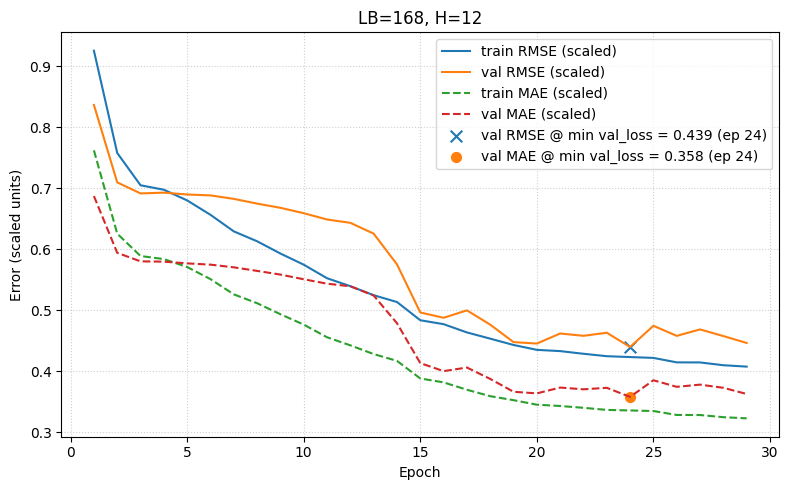

Selected epoch: 24 (min val_loss)
Valid @ sel —  MAE: 0.3577 | RMSE: 0.4394 (scaled)
Train @ sel —  MAE: 0.3354  | RMSE: 0.423 (scaled)
Lookback=168, Horizon=12 -> Val MAE=0.357651

LB=168, H=24

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.9251 - mae: 0.7928 - rmse: 0.9615 - val_loss: 1.1423 - val_mae: 0.8852 - val_rmse: 1.0688
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6653 - mae: 0.6697 - rmse: 0.8154 - val_loss: 0.7967 - val_mae: 0.7296 - val_rmse: 0.8926
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5312 - mae: 0.6048 - rmse: 0.7287 - val_loss: 0.5762 - val_mae: 0.6249 - val_rmse: 0.7591
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4639 - mae: 0.5688 - rmse: 0.6811 - val_loss: 0.4779 - val_mae: 0.5767 - val_rmse: 0.6913
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4230 - mae: 0.5433 - rmse: 0.6503 - val_loss: 0.4287 - val_mae: 0.5527 - val_rmse: 0.6548
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/ste

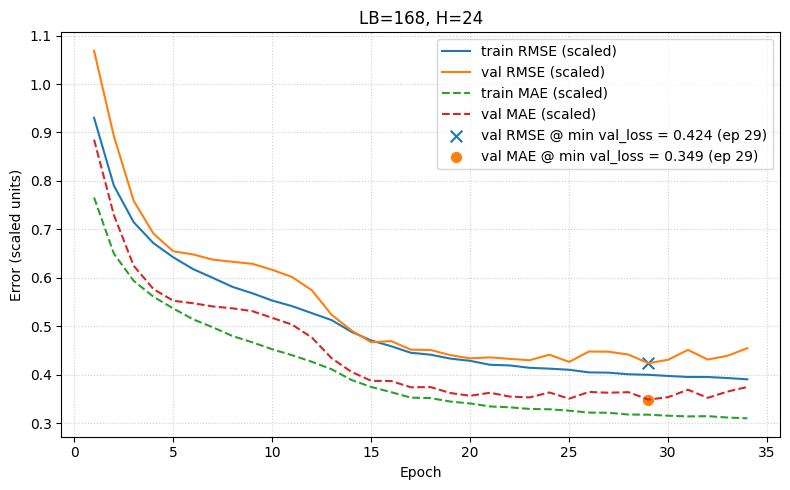

Selected epoch: 29 (min val_loss)
Valid @ sel —  MAE: 0.3485 | RMSE: 0.4237 (scaled)
Train @ sel —  MAE: 0.3174  | RMSE: 0.3998 (scaled)
Lookback=168, Horizon=24 -> Val MAE=0.348507

a1 = 0.075784


In [60]:
# Your code here, add as many cells as you like

def test_config(lookback, horizon):
    """Test a single lookback/horizon configuration"""

    train = s6.iloc[:n_train]
    val = s6.iloc[n_train:n_train+n_val]
    test = s6.iloc[n_train+n_val:]

    scaler_local = StandardScaler()
    train_x = scaler_local.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
    val_x = scaler_local.transform(val.values.reshape(-1,1)).astype(np.float32)
    test_x = scaler_local.transform(test.values.reshape(-1,1)).astype(np.float32)

    def make_windows(arr, lb, h):
        X, y = [], []
        for i in range(lb, len(arr)-h+1):
            X.append(arr[i-lb:i, 0])
            y.append(arr[i:i+h, 0])
        return np.array(X, dtype=np.float32)[..., None], np.array(y, dtype=np.float32)

    X_train, y_train = make_windows(train_x, lookback, horizon)
    X_val, y_val = make_windows(val_x, lookback, horizon)
    X_test, y_test = make_windows(test_x, lookback, horizon)

    model = Sequential([
        Input(shape=(lookback, 1)),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation="relu", kernel_initializer=he),
        Dense(horizon)
    ])

    history, test_results, info = train_and_test(
        model, X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val, X_test=X_test, y_test=y_test,
        title=f"LB={lookback}, H={horizon}",
        epochs=50, batch_size=64, verbose=1, return_history=True
    )

    return info['val_at_sel']['mae']

configs = [
    (24, 1),
    (72, 1),
    (168, 1),
    (336, 1),
    (168, 6),
    (168, 12),
    (168, 24),
]

best_mae = float('inf')
for lb, h in configs:
    val_mae = test_config(lb, h)
    print(f"Lookback={lb}, Horizon={h} -> Val MAE={val_mae:.6f}")
    if val_mae < best_mae:
        best_mae = val_mae

a1 = best_mae
print(f"\na1 = {a1:.6f}")

### Graded Questions

In [61]:
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse) for your best choices of lookback and horizon

a1a = 0.075784             # Replace 0.0 with your answer

In [62]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a1a = {a1a:.4f}')

a1a = 0.0758


#### Question a1b: Describe below your experiments. What effect did your changes to the lookback and horizon have? Did you get an improvement in the validation MAE?  

#### Your Answer Here:

For this problem, I tried different combinations of lookback and horizon to understand how validation MAE was affected. I tested lookbacks of 24 hours, 72 hours, 168 hours, and 336 hours and forecast horizons of 1 hour, 6 hours, 12 hours, and 24 hours. I observed that increasing 24 hours (1 day) to 168 hours (1 week) for lookback improved performance but when the lookback extended to 336 hours (2 weeks) little to no improvement occurred while training time increased. While keeping the lookback at 168 hours (the best performance) and increasing the horizon values, it was determined the best MAE was at 1 hour. Increasing the horizon value to 6, 12, and 24 hours did not improve the model's performance. Therefore, the best validation MAE was reached at 168 hour lookback and 1 hour horizon.



## Problem Two — Architectural Tweaks

Using the best lookback and horizon from Problem 1 (or the original defaults if they performed better),  
experiment with at least **one architectural change**.  

Possible options:
- Add a deeper “head” (e.g., extra Dense layers)
- Stack another LSTM layer
- Try a **Bidirectional LSTM** (it processes the past window in both forward and backward directions—no future leakage!)

Train, evaluate, and answer the graded questions.  


Using Lookback=168, Horizon=1
X_train: (2368, 168, 1), y_train: (2368, 1)

ARCHITECTURE 1: BASELINE

Arch 1: Baseline

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7008 - mae: 0.6778 - rmse: 0.8323 - val_loss: 0.3702 - val_mae: 0.5150 - val_rmse: 0.6085
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3684 - mae: 0.5141 - rmse: 0.6065 - val_loss: 0.3306 - val_mae: 0.4844 - val_rmse: 0.5750
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3151 - mae: 0.4786 - rmse: 0.5608 - val_loss: 0.2529 - val_mae: 0.4215 - val_rmse: 0.5029
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2340 - mae: 0.4080 - rmse: 0.4834 - val_loss: 0.1465 - val_mae: 0.3270 - val_rmse: 0.3827
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1663 - mae: 0.3308 - rmse: 0.4074 - val_loss: 0.0896 - val_mae: 0.2607 - val_rmse: 0.2993
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1219 - mae: 0.2817 - rmse: 0.3490 - val_loss: 0.0737 - val_mae: 0

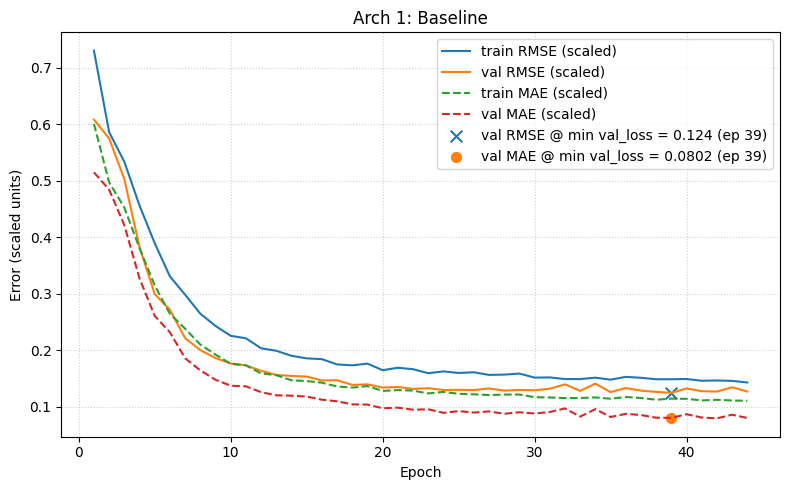

Selected epoch: 39 (min val_loss)
Valid @ sel —  MAE: 0.08019 | RMSE: 0.1245 (scaled)
Train @ sel —  MAE: 0.1142  | RMSE: 0.1486 (scaled)
ARCHITECTURE 2: DEEPER HEAD

Arch 2: Deeper Head

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.7737 - mae: 0.7035 - rmse: 0.8788 - val_loss: 0.3609 - val_mae: 0.4903 - val_rmse: 0.6007
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6271 - mae: 0.6231 - rmse: 0.7918 - val_loss: 0.2554 - val_mae: 0.4105 - val_rmse: 0.5054
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5622 - mae: 0.5785 - rmse: 0.7497 - val_loss: 0.1588 - val_mae: 0.3288 - val_rmse: 0.3985
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4960 - mae: 0.5268 - rmse: 0.7042 - val_loss: 0.0840 - val_mae: 0.2524 - val_rmse: 0.2899
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4507 - mae: 0.4869 - rmse: 0.6712 - val_loss: 0.0572 - val_mae: 0.2026 - val_rmse: 0.2392
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss

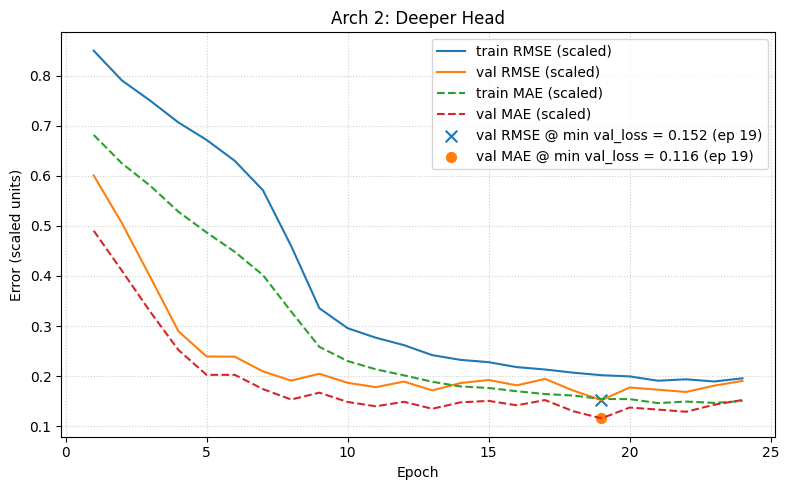

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.1158 | RMSE: 0.1522 (scaled)
Train @ sel —  MAE: 0.1544  | RMSE: 0.2019 (scaled)
ARCHITECTURE 3: STACKED LSTM

Arch 3: Stacked LSTM

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7958 - mae: 0.7259 - rmse: 0.8872 - val_loss: 0.4931 - val_mae: 0.5826 - val_rmse: 0.7022
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4806 - mae: 0.5921 - rmse: 0.6927 - val_loss: 0.4238 - val_mae: 0.5461 - val_rmse: 0.6510
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.4252 - mae: 0.5538 - rmse: 0.6515 - val_loss: 0.3999 - val_mae: 0.5279 - val_rmse: 0.6324
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3421 - mae: 0.4977 - rmse: 0.5843 - val_loss: 0.3212 - val_mae: 0.4770 - val_rmse: 0.5667
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2790 - mae: 0.4434 - rmse: 0.5280 - val_loss: 0.2347 - val_mae: 0.4114 - val_rmse: 0.4844
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - los

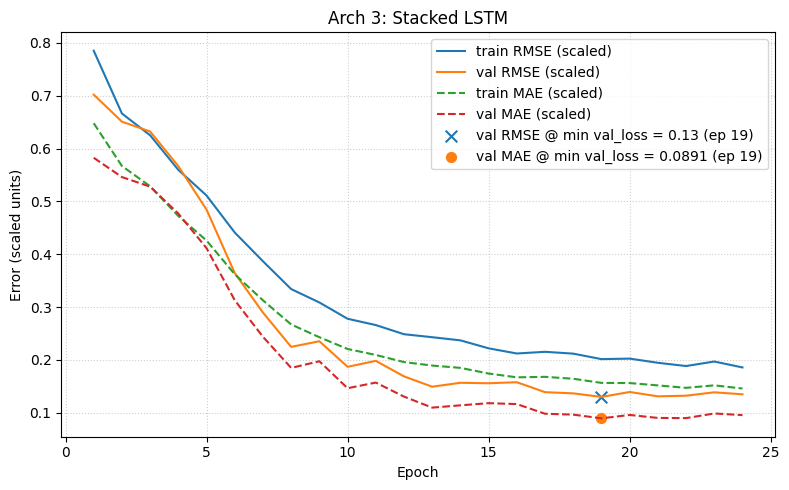

Selected epoch: 19 (min val_loss)
Valid @ sel —  MAE: 0.08915 | RMSE: 0.1297 (scaled)
Train @ sel —  MAE: 0.1563  | RMSE: 0.2013 (scaled)
ARCHITECTURE 4: BIDIRECTIONAL LSTM

Arch 4: Bidirectional LSTM

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.7983 - mae: 0.7150 - rmse: 0.8879 - val_loss: 0.2719 - val_mae: 0.4502 - val_rmse: 0.5214
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3151 - mae: 0.4660 - rmse: 0.5604 - val_loss: 0.1889 - val_mae: 0.3747 - val_rmse: 0.4347
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1903 - mae: 0.3592 - rmse: 0.4359 - val_loss: 0.1068 - val_mae: 0.2791 - val_rmse: 0.3267
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1397 - mae: 0.2975 - rmse: 0.3736 - val_loss: 0.0864 - val_mae: 0.2497 - val_rmse: 0.2940
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1130 - mae: 0.2681 - rmse: 0.3360 - val_loss: 0.0665 - val_mae: 0.2183 - val_rmse: 0.2578
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 16

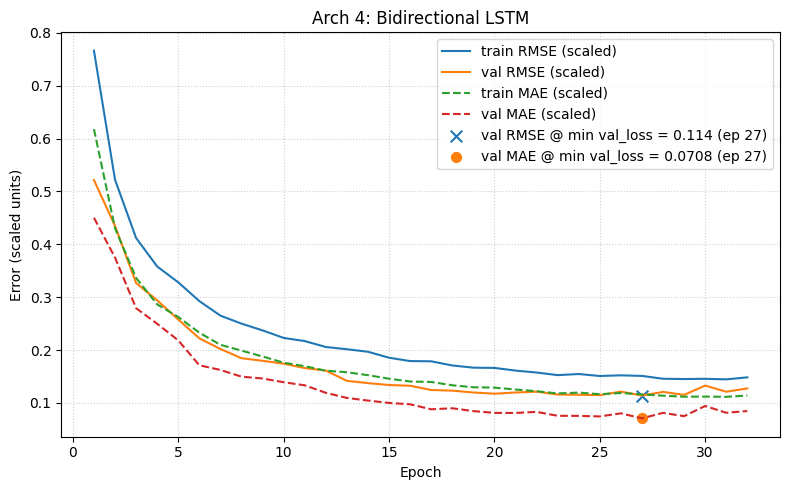

Selected epoch: 27 (min val_loss)
Valid @ sel —  MAE: 0.07085 | RMSE: 0.114 (scaled)
Train @ sel —  MAE: 0.1162  | RMSE: 0.1511 (scaled)
ARCHITECTURE 5: STACKED BIDIRECTIONAL LSTM

Arch 5: Stacked Bidirectional

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.6034 - mae: 0.6351 - rmse: 0.7719 - val_loss: 0.3192 - val_mae: 0.4780 - val_rmse: 0.5650
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2848 - mae: 0.4458 - rmse: 0.5329 - val_loss: 0.1596 - val_mae: 0.3473 - val_rmse: 0.3994
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1833 - mae: 0.3449 - rmse: 0.4281 - val_loss: 0.1117 - val_mae: 0.2834 - val_rmse: 0.3342
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1561 - mae: 0.3189 - rmse: 0.3949 - val_loss: 0.0704 - val_mae: 0.2304 - val_rmse: 0.2653
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.1166 - mae: 0.2745 - rmse: 0.3414 - val_loss: 0.0576 - val_mae: 0.2044 - val_rmse: 0.2399
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━

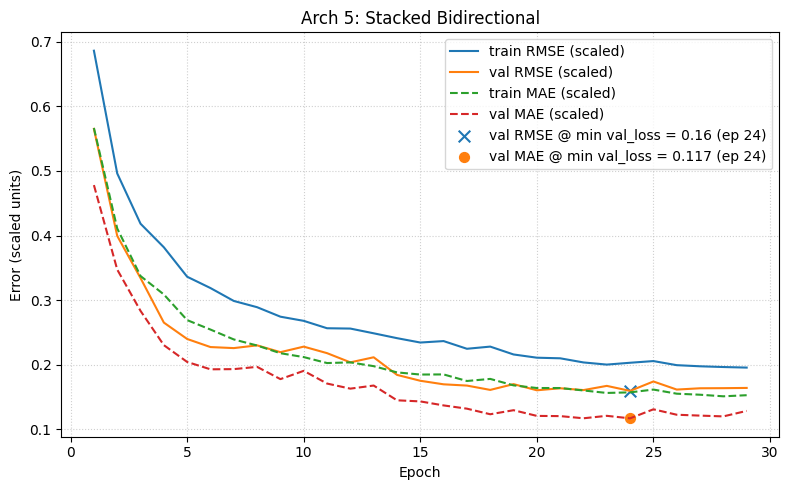

Selected epoch: 24 (min val_loss)
Valid @ sel —  MAE: 0.1172 | RMSE: 0.1597 (scaled)
Train @ sel —  MAE: 0.1574  | RMSE: 0.2032 (scaled)
ARCHITECTURE COMPARISON SUMMARY

All experiments ranked by validation MAE:
Arch 4: Bidirectional LSTM           val_RMSE@min_val_loss=0.114 | val_MAE@min_val_loss=0.07085 | epoch=27  (scaled)
LB=168, H=1                          val_RMSE@min_val_loss=0.1239 | val_MAE@min_val_loss=0.07578 | epoch=35  (scaled)
LB=24, H=1                           val_RMSE@min_val_loss=0.1129 | val_MAE@min_val_loss=0.07743 | epoch=22  (scaled)
Arch 1: Baseline                     val_RMSE@min_val_loss=0.1245 | val_MAE@min_val_loss=0.08019 | epoch=39  (scaled)
LB=72, H=1                           val_RMSE@min_val_loss=0.1284 | val_MAE@min_val_loss=0.08624 | epoch=19  (scaled)
Arch 3: Stacked LSTM                 val_RMSE@min_val_loss=0.1297 | val_MAE@min_val_loss=0.08915 | epoch=19  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_v

In [63]:
# Your code here, add as many cells as you like

BEST_LOOKBACK = 168
BEST_HORIZON = 1

train = s6.iloc[:n_train]
val = s6.iloc[n_train:n_train+n_val]
test = s6.iloc[n_train+n_val:]

scaler_arch = StandardScaler()
train_x = scaler_arch.fit_transform(train.values.reshape(-1,1)).astype(np.float32)
val_x = scaler_arch.transform(val.values.reshape(-1,1)).astype(np.float32)
test_x = scaler_arch.transform(test.values.reshape(-1,1)).astype(np.float32)

def make_windows(arr, lb, h):
    X, y = [], []
    for i in range(lb, len(arr)-h+1):
        X.append(arr[i-lb:i, 0])
        y.append(arr[i:i+h, 0])
    return np.array(X, dtype=np.float32)[..., None], np.array(y, dtype=np.float32)

X_train, y_train = make_windows(train_x, BEST_LOOKBACK, BEST_HORIZON)
X_val, y_val = make_windows(val_x, BEST_LOOKBACK, BEST_HORIZON)
X_test, y_test = make_windows(test_x, BEST_LOOKBACK, BEST_HORIZON)

print(f"Using Lookback={BEST_LOOKBACK}, Horizon={BEST_HORIZON}")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}\n")

arch_results = {}

# ARCHITECTURE 1: BASELINE
print("ARCHITECTURE 1: BASELINE")

model_baseline = Sequential([
    Input(shape=(BEST_LOOKBACK, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(BEST_HORIZON)
], name="Baseline")

history_1, test_1, info_1 = train_and_test(
    model_baseline,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    title="Arch 1: Baseline",
    epochs=50, batch_size=64, verbose=1, return_history=True
)

arch_results['baseline'] = {
    'val_mae': info_1['val_at_sel']['mae'],
    'val_rmse': info_1['val_at_sel']['rmse'],
    'test': test_1
}

# ARCHITECTURE 2: DEEPER HEAD (More Dense Layers)
print("ARCHITECTURE 2: DEEPER HEAD")

model_deeper = Sequential([
    Input(shape=(BEST_LOOKBACK, 1)),
    LSTM(32),
    Dropout(0.2),
    Dense(32, activation="relu", kernel_initializer=he),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(8, activation="relu", kernel_initializer=he),
    Dense(BEST_HORIZON)
], name="Deeper_Head")

history_2, test_2, info_2 = train_and_test(
    model_deeper,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    title="Arch 2: Deeper Head",
    epochs=50, batch_size=64, verbose=1, return_history=True
)

arch_results['deeper_head'] = {
    'val_mae': info_2['val_at_sel']['mae'],
    'val_rmse': info_2['val_at_sel']['rmse'],
    'test': test_2
}

# ARCHITECTURE 3: STACKED LSTM
print("ARCHITECTURE 3: STACKED LSTM")

model_stacked = Sequential([
    Input(shape=(BEST_LOOKBACK, 1)),
    LSTM(32, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(BEST_HORIZON)
], name="Stacked_LSTM")

history_3, test_3, info_3 = train_and_test(
    model_stacked,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    title="Arch 3: Stacked LSTM",
    epochs=50, batch_size=64, verbose=1, return_history=True
)

arch_results['stacked_lstm'] = {
    'val_mae': info_3['val_at_sel']['mae'],
    'val_rmse': info_3['val_at_sel']['rmse'],
    'test': test_3
}

# ARCHITECTURE 4: BIDIRECTIONAL LSTM

print("ARCHITECTURE 4: BIDIRECTIONAL LSTM")

model_bidirectional = Sequential([
    Input(shape=(BEST_LOOKBACK, 1)),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(BEST_HORIZON)
], name="Bidirectional_LSTM")

history_4, test_4, info_4 = train_and_test(
    model_bidirectional,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    title="Arch 4: Bidirectional LSTM",
    epochs=50, batch_size=64, verbose=1, return_history=True
)

arch_results['bidirectional'] = {
    'val_mae': info_4['val_at_sel']['mae'],
    'val_rmse': info_4['val_at_sel']['rmse'],
    'test': test_4
}

# ARCHITECTURE 5: COMBINED (Stacked + Bidirectional)
print("ARCHITECTURE 5: STACKED BIDIRECTIONAL LSTM")

model_combined = Sequential([
    Input(shape=(BEST_LOOKBACK, 1)),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(16)),
    Dropout(0.2),
    Dense(16, activation="relu", kernel_initializer=he),
    Dense(BEST_HORIZON)
], name="Stacked_Bidirectional")

history_5, test_5, info_5 = train_and_test(
    model_combined,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    X_test=X_test, y_test=y_test,
    title="Arch 5: Stacked Bidirectional",
    epochs=50, batch_size=64, verbose=1, return_history=True
)

arch_results['stacked_bidirectional'] = {
    'val_mae': info_5['val_at_sel']['mae'],
    'val_rmse': info_5['val_at_sel']['rmse'],
    'test': test_5
}

print("ARCHITECTURE COMPARISON SUMMARY")

print("\nAll experiments ranked by validation MAE:")
print_results(sort_by="val_mae_at_min_valloss")

print("DETAILED COMPARISON")

for name, res in arch_results.items():
    print(f"{name:25} | Val MAE: {res['val_mae']:.6f} | Val RMSE: {res['val_rmse']:.6f}")

best_arch = min(arch_results.items(), key=lambda x: x[1]['val_mae'])
best_name, best_res = best_arch

print("BEST ARCHITECTURE")
print(f"Winner: {best_name}")
print(f"Validation MAE: {best_res['val_mae']:.6f}")
print(f"Validation RMSE: {best_res['val_rmse']:.6f}")

print("ANSWER FOR PROBLEM 2")

a2 = best_res['val_mae']

print(f"a2 = {a2:.6f}  # Best validation MAE from architectural experiments")
print(f"# Architecture: {best_name}")

print(f"\n✓ Variable a2 has been set to: {a2:.6f}")
print(f"✓ Best architecture: {best_name}")

### Graded Questions

In [69]:
# Set a1 to the Validation MAE at the epoch of minimum validation loss (mse)

a2a = 0.070846            # Replace 0.0 with your answer

In [70]:
# Graded Answer
# DO NOT change this cell in any way

print(f'a2a = {a2a:.4f}')

a2a = 0.0708


#### Question a2b: Describe below your experiments and what you observed. Did you get a better validation MAE through architectural changes?  

#### Your Answer Here:

For problem 2, I experimented with five different architectures: baseline, deeper head with three dense layers, stacked lstm with two recurrent layers, a bidirectional LSTM, and a combined architecture of stacked and bidirectional. The fourth architecture, a bidirectional LSTM, performed the best producing a validation MAE of 0.070846. This was about a 11.5% improvement over the baseline. The other architectures, deeper head, stacked LSTM, and stacked+bidirectional, all performed worse than the baseline. This indicates that adding complexity to the model more likely caused it to overfit to the data than assist with generalization. Overall, this problem displayed that bidirectional processing was more helpful for temporal patterns than dense or stacking layers.



## Problem Three — Autoregressive Forecasting (ChatGPT Discussion)

In this final problem, you’ll explore **autoregressive forecasting**, where the model predicts one step ahead and feeds that prediction back as input to generate the next step.

**Your task:**
1. Briefly describe your current model to ChatGPT (e.g., “My LSTM predicts the next 24 hours directly from the past 168 hours.”), or share a short code snippet.  
2. Ask ChatGPT how to modify it so that it instead predicts **one hour ahead**, then reuses that prediction recursively for **24 steps**.  
3. Implement or outline the version it suggests.  
4. Answer the graded question.


In [66]:
# Your code here, add as many cells as you like

model = model_bidirectional

lookback = 168
horizon = 1

last_window = X_test[-1].copy()
predictions = []

for step in range(24):
    pred = model.predict(last_window.reshape(1, lookback, 1), verbose=0)

    predictions.append(pred[0, 0])

    last_window = np.vstack([last_window[1:], pred])



In [67]:
# Calculate error at each step (you need ground truth for next 24 hours)
true_values = y_test[-24:]
predictions_array = np.array(predictions)

errors = np.abs(true_values.flatten() - predictions_array)
print(f"Error at hour 1:  {errors[0]:.4f}")
print(f"Error at hour 12: {errors[11]:.4f}")
print(f"Error at hour 24: {errors[23]:.4f}")

Error at hour 1:  0.0355
Error at hour 12: 0.6078
Error at hour 24: 0.1702


### Graded Questions

#### Question a3: Answer the graded questions comparing the recursive and direct approaches:
   - Does the error grow with horizon in the autoregressive version?
   - Which approach you tried in this homework performs better overall?

#### Your Answer Here:

1) In the autoregressive version, the error does grow with horizon. In the first hour the error is very low with 0.0355. By hour 12 though, the error grows largely to 0.6078. By hour 24, the error did decrease to 0.1702, but still a large difference exists between hour 1 and hour 24. These results indicate that recursive forecasting is unstable and faces compounding errors.

2) The best approach in this homework was the Bidirectional LSTM which produced the lowest MAE of 0.07085.

In [68]:
print_results()

LB=24, H=1                           val_RMSE@min_val_loss=0.1129 | val_MAE@min_val_loss=0.07743 | epoch=22  (scaled)
Arch 4: Bidirectional LSTM           val_RMSE@min_val_loss=0.114 | val_MAE@min_val_loss=0.07085 | epoch=27  (scaled)
LB=168, H=1                          val_RMSE@min_val_loss=0.1239 | val_MAE@min_val_loss=0.07578 | epoch=35  (scaled)
Arch 1: Baseline                     val_RMSE@min_val_loss=0.1245 | val_MAE@min_val_loss=0.08019 | epoch=39  (scaled)
LB=72, H=1                           val_RMSE@min_val_loss=0.1284 | val_MAE@min_val_loss=0.08624 | epoch=19  (scaled)
Arch 3: Stacked LSTM                 val_RMSE@min_val_loss=0.1297 | val_MAE@min_val_loss=0.08915 | epoch=19  (scaled)
Baseline Model                       val_RMSE@min_val_loss=0.1311 | val_MAE@min_val_loss=0.09209 | epoch=19  (scaled)
Arch 2: Deeper Head                  val_RMSE@min_val_loss=0.1522 | val_MAE@min_val_loss=0.1158 | epoch=19  (scaled)
LB=336, H=1                          val_RMSE@min_val_loss